<a href="https://colab.research.google.com/github/yapkhaichuen/lunchbox/blob/main/light_leaks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Light leaks


This project is a photographic post-processing tool designed to add natural-looking, film-inspired light leaks to images while intelligently avoiding faces using advanced face detection. It supports single and batch processing, auto-clears intermediate previews, and runs efficiently with optimized Gaussian blur.

#### Key Features:
1. Face-Aware Light Leak Placement using:
MTCNN for high-quality detection.
Fallback to LBP and Haar Profile for side-profile and robustness.
2. Fast Gaussian Blur using OpenCV for speed.
3. Batch processing with auto directory handling.
4. Inline face detection previews (for notebooks) and preview images saved in a cache folder.
5. Cleanup utility to remove all generated files.


## Define functions

In [ ]:
!pip -q install facenet_pytorch

In [ ]:
import os
import shutil
import cv2
import numpy as np
from PIL import Image
from facenet_pytorch import MTCNN
import torch
import matplotlib.pyplot as plt
import urllib.request

# -------- SETUP --------
device = 'cuda' if torch.cuda.is_available() else 'cpu'
mtcnn = MTCNN(keep_all=True, thresholds=[0.8, 0.85, 0.95], min_face_size=50, device=device)


# -------- UTILITY --------
def clear_directory(path):
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)
    print(f"Cleared: {path}")


# -------- FACE DETECTION --------
def detect_faces(image, min_confidence=0.9):
    # Primary: MTCNN
    boxes, probs = mtcnn.detect(image)
    if boxes is not None and probs is not None:
        faces = [tuple(map(int, box)) for box, p in zip(boxes, probs) if p and p >= min_confidence]
        if faces:
            return faces

    # Fallback: OpenCV LBP (auto-download if not found)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    lbp_path = os.path.join(cv2.data.haarcascades, 'lbpcascade_frontalface_improved.xml')
    if not os.path.exists(lbp_path):
        print("⬇️ Downloading LBP cascade...")
        lbp_url = 'https://raw.githubusercontent.com/opencv/opencv/master/data/lbpcascades/lbpcascade_frontalface_improved.xml'
        try:
            urllib.request.urlretrieve(lbp_url, lbp_path)
        except Exception as e:
            print(f"⚠️ Could not download LBP cascade: {e}")

    if not os.path.exists(lbp_path):
        print("⚠️ LBP cascade could not be downloaded. Falling back to Haar.")
        lbp_path = os.path.join(cv2.data.haarcascades, 'haarcascade_frontalface_default.xml')

    detector = cv2.CascadeClassifier(lbp_path)
    fallback_faces = detector.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=4)
    if len(fallback_faces) > 0:
        return [tuple((x, y, x + w, y + h)) for (x, y, w, h) in fallback_faces]

    # Fallback: Haar Profile (for side faces)
    profile_path = os.path.join(cv2.data.haarcascades, 'haarcascade_profileface.xml')
    profile_detector = cv2.CascadeClassifier(profile_path)
    profile_faces = profile_detector.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=4)
    if len(profile_faces) > 0:
        return [tuple((x, y, x + w, y + h)) for (x, y, w, h) in profile_faces]

    # Final fallback: return empty list
    return []


# -------- LIGHT LEAK FUNCTIONS --------
def random_color():
    palette = [
        np.array([1.0, np.random.uniform(0.2, 0.4), 0.0]),
        np.array([1.0, 0.0, np.random.uniform(0.2, 0.6)]),
        np.array([np.random.uniform(0.8, 1.0), np.random.uniform(0.3, 0.6), 0.0]),
        np.array([np.random.uniform(0.7, 1.0), 0.0, np.random.uniform(0.3, 0.6)]),
    ]
    color_a = palette[np.random.randint(len(palette))]
    color_b = palette[np.random.randint(len(palette))]
    return color_a, color_b

def gaussian_blur_fast(image, sigma):
    ksize = int(2 * round(sigma * 3) + 1)
    ksize = max(3, ksize | 1)
    return cv2.GaussianBlur(image, (ksize, ksize), sigmaX=sigma, sigmaY=sigma)

def generate_light_leak_mask(shape, faces=None, num_leaks=3):
    h, w = shape[:2]
    final_mask = np.zeros((h, w), dtype=np.float32)
    y, x = np.ogrid[:h, :w]
    center_x, center_y = w / 2, h / 2
    distance = np.sqrt((x - center_x)**2 + (y - center_y)**2)
    prob_map = (distance / distance.max())**2

    face_mask = np.ones((h, w), dtype=np.float32)
    if faces:
        for (x1, y1, x2, y2) in faces:
            x1c, y1c = max(x1, 0), max(y1, 0)
            x2c, y2c = min(x2, w), min(y2, h)
            face_mask[y1c:y2c, x1c:x2c] = 0.0
        prob_map *= face_mask

    prob_map /= prob_map.sum() + 1e-8
    coords = np.argwhere(prob_map > 0)

    for _ in range(num_leaks):
        for attempt in range(30):
            idx = np.random.choice(len(coords))
            cy, cx = coords[idx]
            shape_type = np.random.choice(['ellipse', 'streak', 'radial'])
            temp = np.zeros_like(final_mask)

            if shape_type == 'ellipse':
                axes = (np.random.randint(w // 10, w // 3), np.random.randint(h // 10, h // 3))
                angle = np.random.uniform(0, 360)
                cv2.ellipse(temp, (cx, cy), axes, angle, 0, 360, color=1, thickness=-1)
            elif shape_type == 'streak':
                length = np.random.randint(w // 4, w)
                thickness = np.random.randint(20, 80)
                angle = np.random.uniform(0, 360)
                dx = int(length * np.cos(np.deg2rad(angle)) / 2)
                dy = int(length * np.sin(np.deg2rad(angle)) / 2)
                pt1 = (np.clip(cx - dx, 0, w-1), np.clip(cy - dy, 0, h-1))
                pt2 = (np.clip(cx + dx, 0, w-1), np.clip(cy + dy, 0, h-1))
                cv2.line(temp, pt1, pt2, color=1, thickness=thickness)
            elif shape_type == 'radial':
                radial = np.zeros_like(temp)
                cv2.circle(radial, (cx, cy), np.random.randint(h//8, h//2), color=1, thickness=-1)
                sigma = np.random.uniform(60, 160)
                temp = gaussian_blur_fast(radial, sigma)

            if np.all(temp * face_mask == temp):
                intensity = np.random.uniform(0.5, 1.2)
                final_mask += temp * intensity
                break

    sigma_final = np.random.uniform(60, 180)
    blurred = gaussian_blur_fast(final_mask, sigma_final)
    blurred = blurred / blurred.max() if blurred.max() > 0 else blurred
    opacity = np.random.uniform(0.4, 0.9)
    return np.clip(blurred * opacity, 0, 1)

def generate_colored_leak(mask):
    mask = mask[..., None]
    color_a, color_b = random_color()
    t = np.random.rand()
    gradient_color = np.clip(color_a + t * (color_b - color_a), 0, 1)
    brightness = np.random.uniform(1.0, 1.6)
    leak_rgb = mask * gradient_color * brightness
    noise = np.random.normal(scale=np.random.uniform(0.01, 0.04), size=mask.shape)
    return np.clip(leak_rgb + noise, 0, 1)

def blend_screen(base, leak):
    return 1 - (1 - base) * (1 - leak)


# -------- SINGLE IMAGE PROCESSING --------
def apply_light_leak(image_path, output_subdir='applied', cache_dir='cache'):
    os.makedirs(cache_dir, exist_ok=True)
    os.makedirs(output_subdir, exist_ok=True)

    img = cv2.imread(image_path)
    if img is None:
        print(f"⚠️ Could not load: {image_path}")
        return

    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_float = rgb_img / 255.0
    faces = detect_faces(rgb_img)
    print(f"  ➤ Faces detected: {len(faces)}")

    preview_img = rgb_img.copy()
    for (x1, y1, x2, y2) in faces:
        cv2.rectangle(preview_img, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)
    preview_filename = os.path.join(cache_dir, os.path.basename(image_path))
    Image.fromarray(preview_img).save(preview_filename)

    # Inline preview in notebooks
    plt.figure(figsize=(6, 4))
    plt.imshow(preview_img)
    plt.title("Detected Face Preview")
    plt.axis('off')
    plt.show()

    combined_leak = np.zeros_like(img_float)
    for _ in range(np.random.randint(2, 5)):
        mask = generate_light_leak_mask(img.shape, faces=faces, num_leaks=1)
        colored_leak = generate_colored_leak(mask)
        combined_leak = blend_screen(combined_leak, colored_leak)

    result = blend_screen(img_float, combined_leak)
    result = np.clip(result * 255, 0, 255).astype(np.uint8)
    output_path = os.path.join(output_subdir, os.path.basename(image_path))
    Image.fromarray(result).save(output_path)
    print(f"  ✅ Saved: {output_path}")


# -------- BATCH PROCESSING --------
def apply_light_leak_batch(source='inputs'):
    cache_dir = os.path.join(source, 'cache')
    clear_directory(cache_dir)

    images = [f for f in os.listdir(source) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    if not images:
        print("⚠️ No images found.")
        return

    print(f"\n📁 Processing {len(images)} image(s) in '{source}'...\n")

    for fname in images:
        img_path = os.path.join(source, fname)
        output_dir = os.path.join(source, 'applied')
        apply_light_leak(img_path, output_subdir=output_dir, cache_dir=cache_dir)


# -------- CLEANUP --------
def cleanup_all(source='inputs'):
    for sub in ['applied', 'cache']:
        full = os.path.join(source, sub)
        if os.path.exists(full):
            shutil.rmtree(full)
            print(f"🧹 Removed: {full}")


## Runtime

In [ ]:
# Run batch from Google Drive!
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Cleared: /content/drive/MyDrive/18-04-2025-Sambutan-Hari-Raya (1)/D7000/cache

📁 Processing 98 image(s) in '/content/drive/MyDrive/18-04-2025-Sambutan-Hari-Raya (1)/D7000'...

  ➤ Faces detected: 8


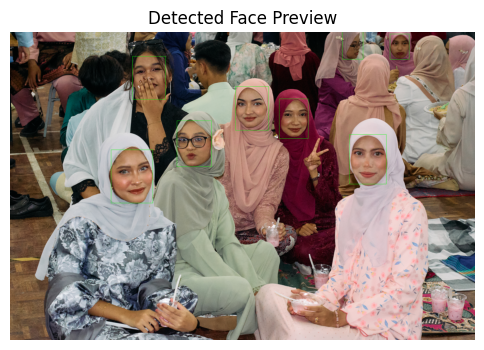

KeyboardInterrupt: 

In [ ]:
# Batch run on 'inputs' folder
apply_light_leak_batch('/content/drive/MyDrive/18-04-2025-Sambutan-Hari-Raya (1)/D7000')


In [ ]:
# Cleans /../applied and /../cache
cleanup_all('morestuff')


🧹 Removed: morestuff/applied
🧹 Removed: morestuff/cache
